In [1]:
import joblib
import pandas as pd
import numpy as np
import logging

FORMAT = "%(asctime)s %(message)s"
logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")


def load_data():
    try:
        path = "/Users/edeno/Downloads/"
        position_info = pd.read_pickle(path + "Jaq_03_16_position_info.pkl")
        spikes = pd.read_pickle(path + "Jaq_03_16_spikes.pkl")
        is_ripple = pd.read_pickle(path + "Jaq_03_16_is_ripple.pkl")
        env = joblib.load(path + "Jaq_03_16_environment.pkl")

        time = np.asarray(position_info.index / np.timedelta64(1, "s"))
        spikes = np.asarray(spikes).astype(float)
        position = np.asarray(position_info.linear_position).astype(float)
        is_ripple = np.asarray(is_ripple).squeeze()
        speed = np.asarray(position_info.nose_vel).astype(float)
    except FileNotFoundError:
        path = "/cumulus/edeno/non_local_paper/notebooks/"
        position_info = pd.read_pickle(path + "Jaq_03_16_position_info.pkl")
        spikes = pd.read_pickle(path + "Jaq_03_16_spikes.pkl")
        is_ripple = pd.read_pickle(path + "Jaq_03_16_is_ripple.pkl")
        env = joblib.load(path + "Jaq_03_16_environment.pkl")

        time = np.asarray(position_info.index / np.timedelta64(1, "s"))
        spikes = np.asarray(spikes).astype(float)
        position = np.asarray(position_info.linear_position).astype(float)
        is_ripple = np.asarray(is_ripple).squeeze()
        speed = np.asarray(position_info.nose_vel).astype(float)

    return is_ripple, spikes, position, speed, env, time

In [2]:
is_ripple, spikes, position, speed, env, time = load_data()

26-Jun-23 15:24:31 Cupy is not installed or GPU is not detected. Ignore this message if not using GPU
/home/edeno/miniconda3/envs/non_local_detector_gpu/lib/python3.10/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from non_local_detector import NonLocalSortedSpikesDetector

detector = NonLocalSortedSpikesDetector(
    environments=env,
    sorted_spikes_algorithm_params={
        "position_std": 6.0,
        "use_diffusion": False,
        "block_size": 10_000,
        "interpolate_local": False,
    },
).fit(position, spikes, is_training=~is_ripple)

26-Jun-23 15:24:35 Fitting initial conditions...
26-Jun-23 15:24:36 Fitting discrete state transition
26-Jun-23 15:24:36 Fitting continuous state transition...
26-Jun-23 15:24:37 Fitting place fields...
2023-06-26 15:24:40.999875: W external/xla/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 0 and 9; status: INTERNAL: failed to enable peer access from 0x7f7e007d6980 to 0x7f7e24625580: CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
2023-06-26 15:24:41.007617: W external/xla/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 1 and 9; status: INTERNAL: failed to enable peer access from 0x7f7df8624fd0 to 0x7f7e24625580: CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
2023-06-26 15:24:41.014310: W external/xla/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 2 and 9; status: INTERNAL: failed to enable peer access from 0x7f7e08624dd0 to 0x7f7e24625580: CUDA_ERROR_TOO_MANY_PEERS: peer mapping r

Encoding models:   0%|          | 0/104 [00:00<?, ?cell/s]

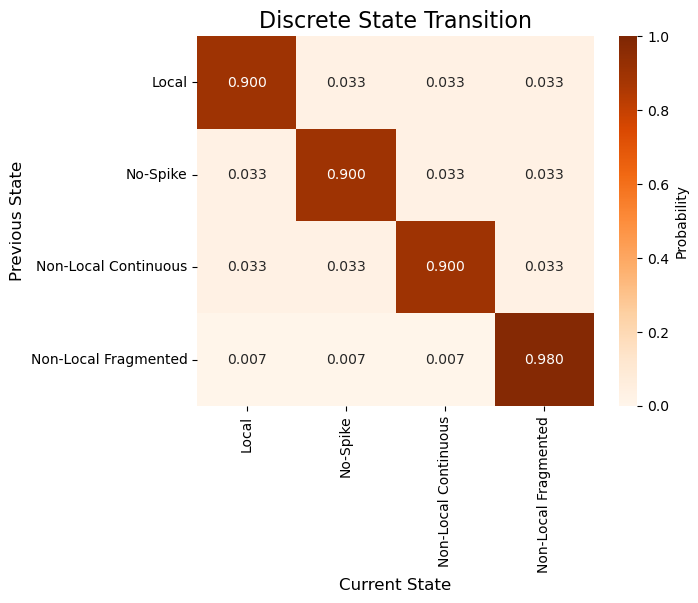

In [4]:
detector.plot_discrete_state_transition()

In [5]:
results = detector.predict(spikes, position, time=time)
results

26-Jun-23 15:25:06 Computing log likelihood...


Local Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

26-Jun-23 15:26:55 Computing posterior...
26-Jun-23 15:27:14 Finished computing posterior...


<xarray.Dataset>
Dimensions:                      (time: 452325, state_bins: 404, states: 4,
                                  state_ind: 404)
Coordinates:
  * time                         (time) float64 2.239e+04 ... 2.329e+04
  * state_bins                   (state_bins) object MultiIndex
  * state                        (state_bins) object 'Local' ... 'Non-Local F...
  * position                     (state_bins) float64 nan nan ... 420.7 422.7
  * state_ind                    (state_ind) int64 0 1 2 2 2 2 2 ... 3 3 3 3 3 3
  * states                       (states) <U20 'Local' ... 'Non-Local Fragmen...
    environments                 (states) <U1 '' '' '' ''
    encoding_groups              (states) int64 0 0 0 0
Data variables:
    acausal_posterior            (time, state_bins) float32 1.0 0.0 ... 0.002966
    acausal_state_probabilities  (time, states) float64 1.0 0.0 ... 0.2649
Attributes:
    marginal_log_likelihoods:  -1921614.6

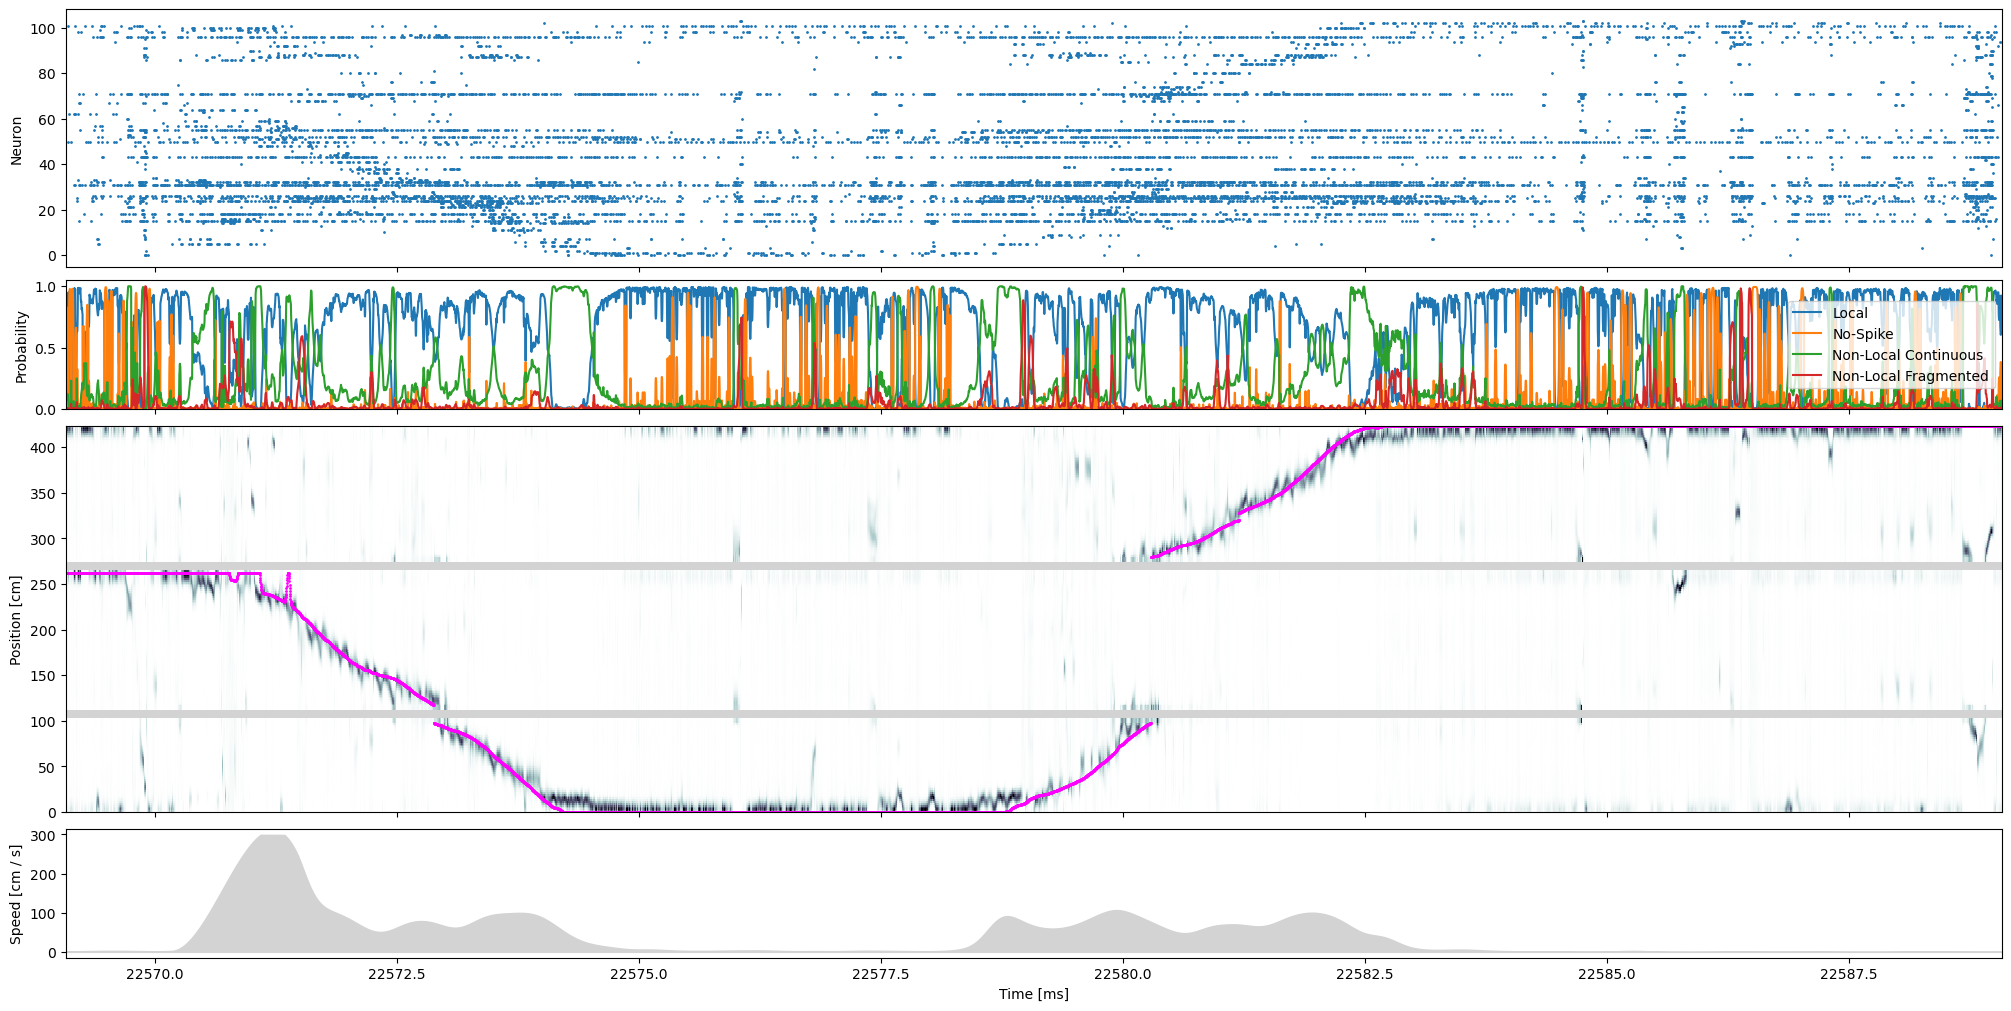

In [6]:
from non_local_detector.visualization import plot_non_local_model

plot_non_local_model(
    time,
    position,
    spikes,
    speed,
    detector,
    results,
    time_slice=slice(90_000, 100_000),
    figsize=(20, 10),
)

In [7]:
results = detector.estimate_parameters(spikes, position, time=time)

26-Jun-23 15:27:22 Fitting initial conditions...
26-Jun-23 15:27:22 Fitting discrete state transition
26-Jun-23 15:27:22 Fitting continuous state transition...
26-Jun-23 15:27:22 Fitting place fields...


Encoding models:   0%|          | 0/104 [00:00<?, ?cell/s]

26-Jun-23 15:27:41 Computing log likelihood...


Local Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

26-Jun-23 15:29:22 Expectation step...
26-Jun-23 15:29:22 Computing posterior...
26-Jun-23 15:29:39 Finished computing posterior...
26-Jun-23 15:29:39 Maximization step..
26-Jun-23 15:29:39 Computing stats..
26-Jun-23 15:29:39 iteration 1, likelihood: -1927115.25
26-Jun-23 15:29:39 Expectation step...
26-Jun-23 15:29:39 Computing posterior...
26-Jun-23 15:29:57 Finished computing posterior...
26-Jun-23 15:29:57 Maximization step..
26-Jun-23 15:29:57 Computing stats..
26-Jun-23 15:29:57 iteration 2, likelihood: -1909971.125, change: 17144.125
26-Jun-23 15:29:57 Expectation step...
26-Jun-23 15:29:57 Computing posterior...
26-Jun-23 15:30:15 Finished computing posterior...
26-Jun-23 15:30:15 Maximization step..
26-Jun-23 15:30:15 Computing stats..
26-Jun-23 15:30:15 iteration 3, likelihood: -1907951.125, change: 2020.0
26-Jun-23 15:30:15 Expectation step...
26-Jun-23 15:30:15 Computing posterior...
26-Jun-23 15:30:32 Finished computing posterior...
26-Jun-23 15:30:32 Maximization step..


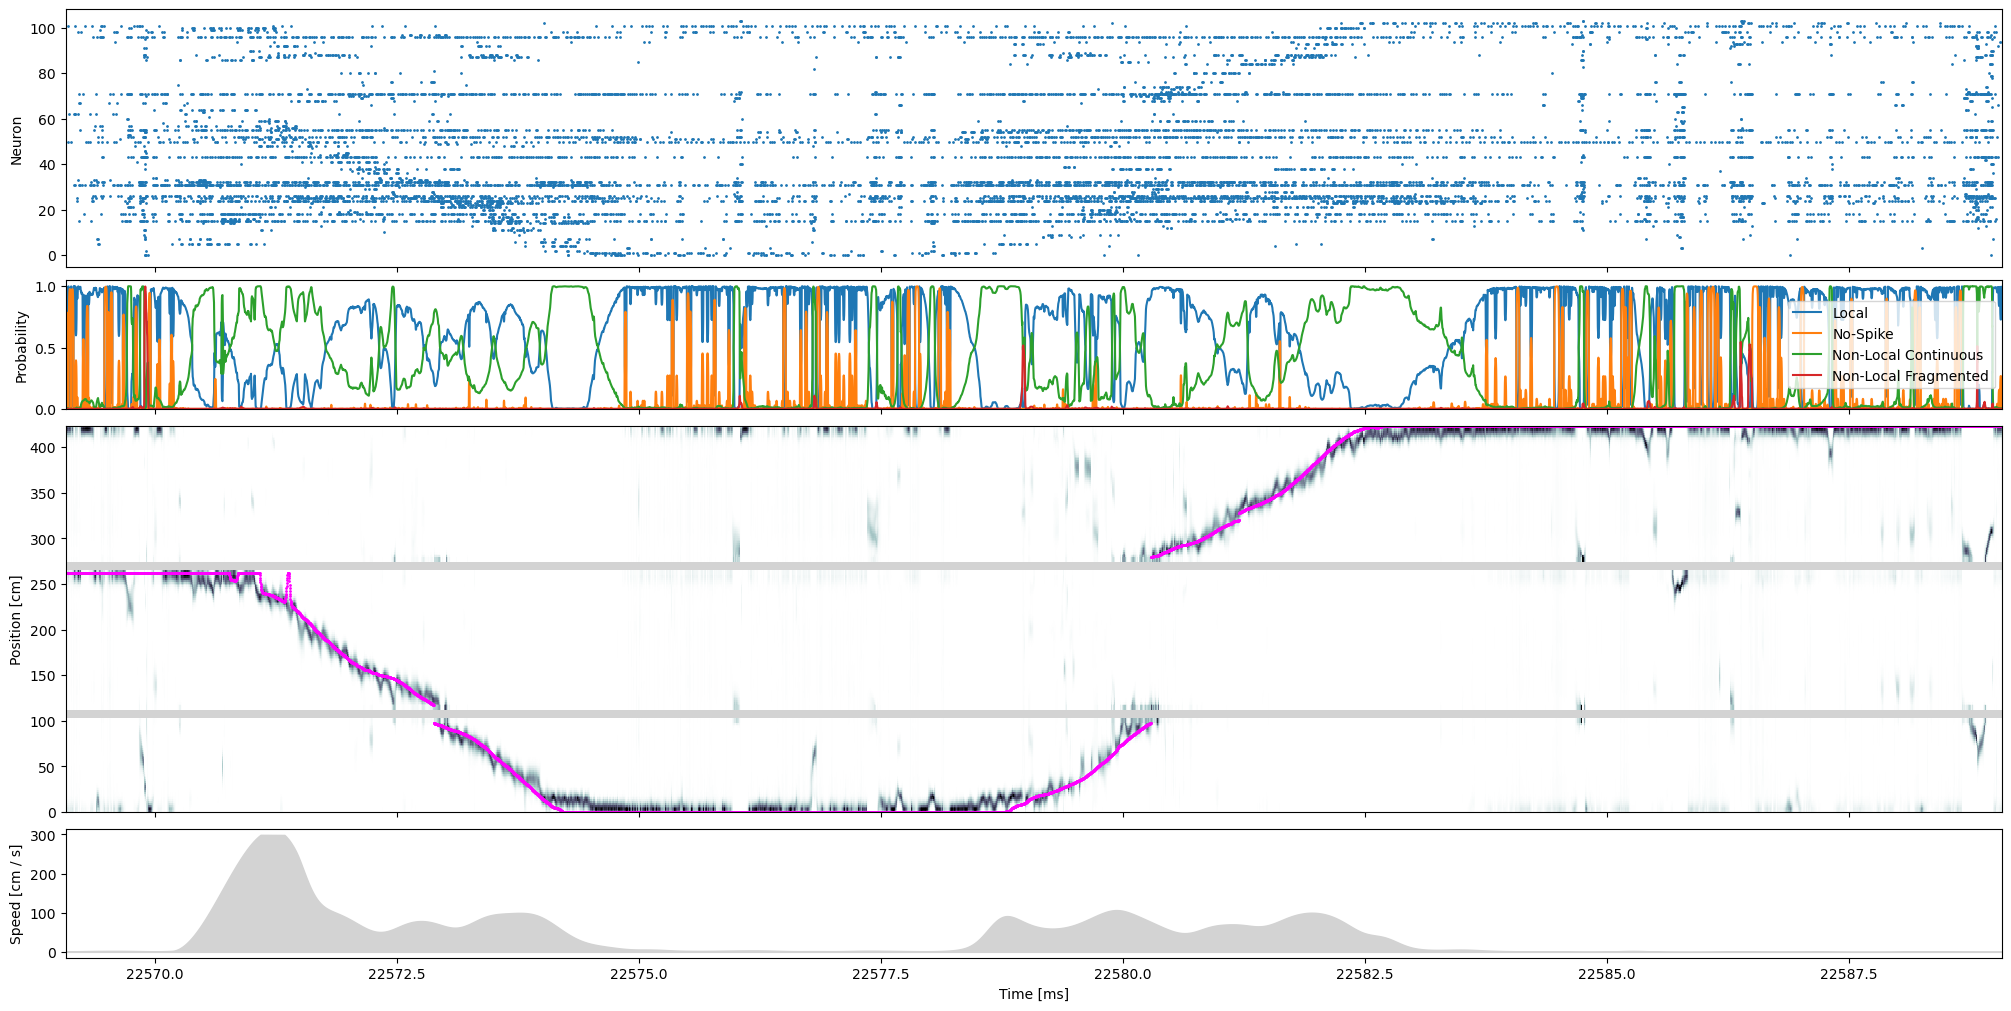

In [8]:
from non_local_detector.visualization import plot_non_local_model

plot_non_local_model(
    time,
    position,
    spikes,
    speed,
    detector,
    results,
    time_slice=slice(90_000, 100_000),
    figsize=(20, 10),
)

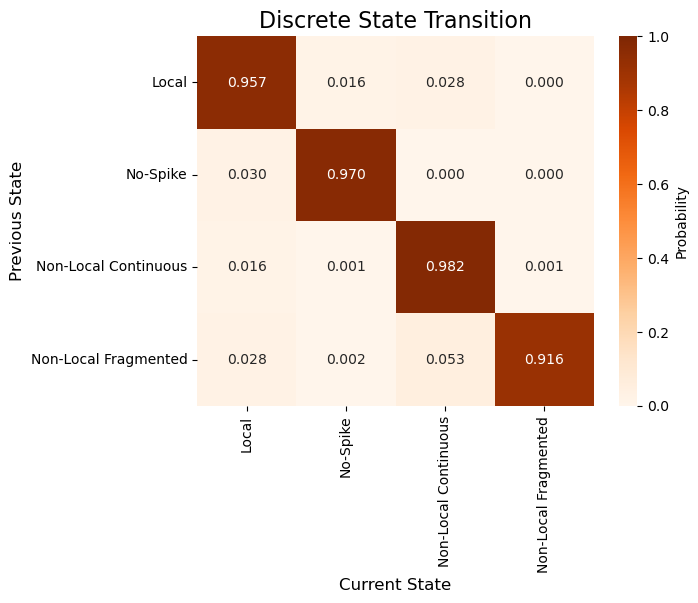

In [9]:
detector.plot_discrete_state_transition()